In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [2]:
# Initial loading and EDA of data
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.drop(index=6, inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
7,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
apple_list = ['iPad', 'Apple', 'iPad or iPhone App', 'Other Apple product or service', 'iPhone']
google_list = ['Google', 'Other Google product or service', 'Android App', 'Android']

df['emotion_in_tweet_is_directed_at'] = ['Apple' if val in apple_list
                                          else val for val in df['emotion_in_tweet_is_directed_at']]

df['emotion_in_tweet_is_directed_at'] = ['Google' if val in google_list
                                          else val for val in df['emotion_in_tweet_is_directed_at']]

df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     2409
Google     882
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
df['emotion_in_tweet_is_directed_at'] = [val if val == 'Apple' or val == 'Google'
                                          else 'Google' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in google_list)
                                          else 'Apple' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in apple_list)
                                          else val
                                          for ind, val in df['emotion_in_tweet_is_directed_at'].iteritems()]

df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     5346
Google    2985
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df2 = df.dropna(axis = 0)
df2 = df2.rename(columns={"emotion_in_tweet_is_directed_at": "product",\
                   "is_there_an_emotion_directed_at_a_brand_or_product":"emotion"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     8331 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
df2_label = pd.DataFrame(df2['emotion'].copy())
emotion = df2_label.replace({"emotion": {"Negative emotion" : 1, 
                                "Positive emotion" : 0, 
                                "No emotion toward brand or product" : 2,
                                "I can't tell" : 3}})
df2['emotion'] = emotion
df2

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,0
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,0
3,@sxsw I hope this year's festival isn't as cra...,Apple,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0
...,...,...,...
9087,Ipad everywhere. #SXSW {link},Apple,0
9088,"Wave, buzz... RT @mention We interrupt your re...",Google,2
9089,"Google's Zeiger, a physician never reported po...",Google,2
9090,Some Verizon iPhone customers complained their...,Apple,2


In [8]:
sw = stopwords.words('english')
pattern = r"(?u)\w{3,}"
tokenizer = RegexpTokenizer(pattern)
stemmer = SnowballStemmer(language = 'english')
def preprocess_text(text, tokenizer, sw, stemmer):
    # Standardize case (lowercase the text)
    # your code here
    text = text.lower()
    
    token = tokenizer.tokenize(text)
    
    text = [word for word in token if word not in sw]

    final = [stemmer.stem(text) for text in text]
    
    return final

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]

    return ' '.join(doc)

In [9]:
X = df2.drop(columns = 'emotion')
y = df2['emotion']

In [10]:
text_series = df["tweet_text"].map(lambda x : preprocess_text(x, tokenizer, sw, stemmer))
text_series


0       [wesley83, iphon, hrs, tweet, rise_austin, dea...
1       [jessede, know, fludapp, awesom, ipad, iphon, ...
2              [swonderlin, wait, ipad, also, sale, sxsw]
3       [sxsw, hope, year, festiv, crashi, year, iphon...
4       [sxtxstate, great, stuff, fri, sxsw, marissa, ...
                              ...                        
9087                        [ipad, everywher, sxsw, link]
9088    [wave, buzz, mention, interrupt, regular, sche...
9089    [googl, zeiger, physician, never, report, pote...
9090    [verizon, iphon, custom, complain, time, fell,...
9091    [ûârt, mention, googl, test, ûïcheck, offer, s...
Name: tweet_text, Length: 9092, dtype: object

sample_document = df['tweet_text'].iloc[1].body

sample_doc = tokenizer.tokenize(sample_document)
sample_doc = [token.lower() for token in sample_doc]
sw = stopwords.words('english')
sample_doc = [token for token in sample_doc if token not in sw]

In [11]:
X_t, X_val, y_t, y_val = train_test_split(X['tweet_text'], y, random_state=42)
y_t

6007    2
2571    0
994     0
8677    2
9056    2
       ..
6253    2
5649    0
5875    2
946     2
7926    2
Name: emotion, Length: 6248, dtype: int64

In [12]:
X_t

6007    RT @mention Hey Austin, know a little about #i...
2571    That sounds...fantastic. RT @mention At the Go...
994     Hey #sxsw peeps! Our new IPhone app ON #Voicef...
8677    GOOGLE &quot;challenge is 2 stay true 2 what o...
9056    @mention You guys should do this &amp; give me...
                              ...                        
6253    RT @mention Line for iPad 2 is longer today th...
5649    RT @mention Cunning Apple, keeping the #iPad2 ...
5875    RT @mention Google to Launch Major New Social ...
946     New batch of iPad 2's just delivered #sxsw #ip...
7926    AmEx Teams Up With Foursquare {link} #GPS #SXS...
Name: tweet_text, Length: 6248, dtype: object

In [13]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
#print(X_t_vec)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)

In [14]:

mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [15]:
X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

Training Accuracy: 0.643783005280845


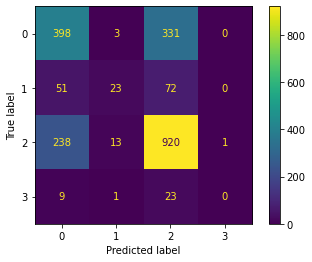

In [16]:
y_preds = mnb.predict(X_val_vec)
print("Training Accuracy:", accuracy_score(y_val, y_preds))
cm = confusion_matrix(y_val, y_preds)
cmdisplay = ConfusionMatrixDisplay(cm)
cmdisplay.plot();

Training Accuracy: 0.7813700384122919


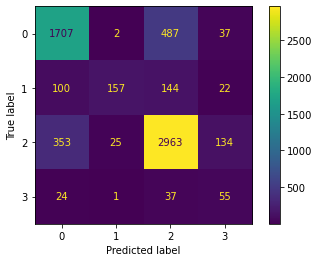

In [17]:
mnb_cv = imbpipeline(steps=[
    ('preprocess', CountVectorizer()),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_cv.fit(X_t, y_t)
preds = mnb_cv.predict(X_t)
print("Training Accuracy:", mnb_cv.score(X_t, y_t))
#mnb.fit(X_train, y_train)
#preds = mnb_cv.predict(X_train)
cm2 = confusion_matrix(y_t, preds)
cm2display = ConfusionMatrixDisplay(cm2)
cm2display.plot();